In [1]:
#import the big 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [25]:
# load in preprocessed data
X_train_pca = pd.read_csv('X_train_pca.csv')
X_test_pca = pd.read_csv('X_test_pca.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [26]:
#verify shape
X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape

((24000, 15), (6000, 15), (24000, 1), (6000, 1))

In [27]:
y_train

,default payment next month
0,0
1,1
2,1
3,0
4,1
...,...
23995,1
23996,0
23997,1
23998,0


In [28]:
#make 1d
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_test

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# default model
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_pca, y_train)
y_pred_default = rf_default.predict(X_test_pca)
print(classification_report(y_test, y_pred_default))
print("Default Random Forest Accuracy:", accuracy_score(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.65      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.74      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Default Random Forest Accuracy: 0.816


In [41]:
#going to sample the data to do a comprehensive search with much smaller size to reduce computation time
from sklearn.model_selection import train_test_split


X_sample, _, y_sample, _ = train_test_split( X_train_pca, y_train, stratify=y_train, test_size=0.8, random_state=42)

In [42]:
X_sample.shape, y_sample.shape #will make much faster for grid search.

((4800, 15), (4800,))

In [43]:
from sklearn.model_selection import GridSearchCV

# create grid with wide range of values
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)

#instaniate
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=3, scoring='accuracy')

#fit
grid_search.fit(X_sample, y_sample)

#best params
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\oconn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\oconn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\oconn\anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\oconn\anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\oconn\anaconda3\lib\site-packa

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [46]:
#refine the grid and repeat the process
param_grid_refined = {
    'n_estimators': [80, 90, 100, 110, 120], #expand around 100
    'max_features': ['sqrt'],  #keep as is
    'max_depth': [5, 6, 7],  # search around 6
    'criterion': ['gini'],  # keep
    'min_samples_split': [4, 5, 6],  #search around best
    'min_samples_leaf': [1],  #keep as is
}
rf = RandomForestClassifier(random_state=42)

#instaniate
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_refined, 
                           cv=3, n_jobs=-1, verbose=3, scoring='accuracy')

#fit
grid_search.fit(X_sample, y_sample)

#best params
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [61]:
# now to fit a model with best hyper params
rf_default = RandomForestClassifier(random_state=42,
                                    criterion='gini',
                                    max_depth=6,
                                    max_features='sqrt',
                                    min_samples_leaf=1,
                                    min_samples_split=5,
                                    n_estimators=100
                                   )

#optimized hyperparams
rf_default.fit(X_train_pca, y_train)
y_pred_default = rf_default.predict(X_test_pca)
print(classification_report(y_test, y_pred_default))
print("Optimized Random Forest Accuracy:", accuracy_score(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.68      0.33      0.44      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000

Optimized Random Forest Accuracy: 0.8175


In [49]:
# SMOTE to 'balance' training  dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)


In [53]:
y_train_smote.shape, y_train.shape

((37382,), (24000,))

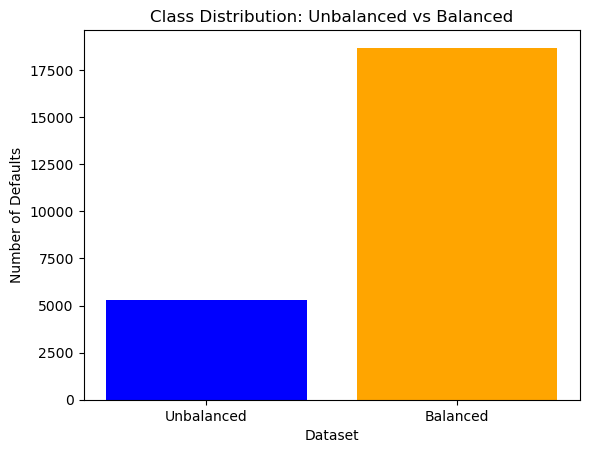

In [58]:
default_unbal = y_train[y_train == 1].sum()
default_bal = y_train_smote[y_train_smote == 1].sum()

classes = ['Unbalanced', 'Balanced']
counts = [default_unbal, default_bal]

#smote chart to show minority class increase in data
plt.bar(classes, counts, color=['blue', 'orange'])

plt.title('Class Distribution: Unbalanced vs Balanced')
plt.xlabel('Dataset')
plt.ylabel('Number of Defaults')
plt.show()

In [60]:

# default SMOTE
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_smote, y_train_smote)
y_pred_default = rf_default.predict(X_test_pca)
print(classification_report(y_test, y_pred_default))
print("Default Random Forest SMOTE Accuracy:", accuracy_score(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4673
           1       0.52      0.52      0.52      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.79      0.79      0.79      6000

Default Random Forest SMOTE Accuracy: 0.7861666666666667


In [66]:
X_sample_SMOTE, _, y_sample_SMOTE, _ = train_test_split( X_train_smote, y_train_smote, \
                                                        stratify=y_train_smote, test_size=0.85, random_state=42)

In [67]:

# create grid with wide range of values
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)

#instaniate
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=3, scoring='accuracy')

#fit
grid_search.fit(X_sample_SMOTE, y_sample_SMOTE) #run on sampled SMOTE data

#best params
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\oconn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
327 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\oconn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\oconn\anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\oconn\anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\oconn\anaconda3\lib\site-packa

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [68]:
print(best_params)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [69]:
#refine grid & repeat
param_grid_refined = {
    'n_estimators': [80, 90, 100, 110, 120], #expand around 100
    'max_features': ['sqrt'],  #keep as is
    'max_depth': [9,10,11,12],  # search around 10
    'criterion': ['gini'],  # keep
    'min_samples_split': [4, 5, 6],  #search around best
    'min_samples_leaf': [1],  #keep as is
}
rf = RandomForestClassifier(random_state=42)

#instaniate
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_refined, 
                           cv=3, n_jobs=-1, verbose=3, scoring='accuracy')

#fit
grid_search.fit(X_sample_SMOTE, y_sample_SMOTE)

#best params
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 110}


In [70]:
#smote best hyperparams
rf_optimized_smote = RandomForestClassifier(random_state=42,
                                    criterion='gini',
                                    max_depth=12,
                                    max_features='sqrt',
                                    min_samples_leaf=1,
                                    min_samples_split=4,
                                    n_estimators=110
                                   )

#optimized hyperparams results
rf_optimized_smote.fit(X_train_smote, y_train_smote)
y_pred_default = rf_optimized_smote.predict(X_test_pca)
print(classification_report(y_test, y_pred_default))
print("Optimized SMOTE Random Forest Accuracy:", accuracy_score(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      4673
           1       0.49      0.59      0.53      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.79      0.77      0.78      6000

Optimized SMOTE Random Forest Accuracy: 0.7736666666666666
